In [1]:
# Bootstrap
import os
import sys

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    
if "src" not in sys.path:
    sys.path.insert(0, "src")

## Notebook Description

This notebook demonstrates how to fit and evaluate the custom `RBFModel` on a
1-dimensional regression task using a noisy sine wave dataset.

### Dataset description

We use the file `data/sine_1sec_4cycles_sigma005.csv`, which contains
time-domain samples of a sine wave. The columns are:

1. **t** — time (seconds)
2. **y_clean** — the clean sine signal
3. **y_noisy** — the sine signal with added Gaussian noise (σ = 0.05)

In this notebook we use **t** as the input feature `X` and **y_noisy** as the
regression target `y`. The clean signal `y_clean` is optionally used for
visual comparison in plots.

### Workflow

- Load the sine dataset from CSV  
- Normalize inputs and targets (normalization is done outside the model)  
- Select RBF centers using KMeans (testing mode for this example)  
- Fit the `RBFModel` to approximate the noisy sine function  
- Visualize the learned function and compute error metrics  

This example provides a clear and intuitive demonstration of how the RBF model
behaves on a smooth 1D signal with noise.


In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from rbf_sa_optimizer.model import RBFModel
from rbf_sa_optimizer.utils import kmeans_clustering

In [3]:
# Load sine dataset from CSV
data_path = Path("data/sine_1sec_4cycles_sigma005.csv")

data = np.genfromtxt(data_path, delimiter=",", skip_header=1)
print("Raw data shape:", data.shape)

# Columns: t, y_clean, y_noisy
t = data[:, 0:1]           # time
y_clean = data[:, 1:2]     # clean sine
y_noisy = data[:, 2:3]     # noisy sine (regression target)

# For training: X = time, y = noisy signal
X = t
y = y_noisy

print("X shape:", X.shape)
print("y shape:", y.shape)

Raw data shape: (500, 3)
X shape: (500, 1)
y shape: (500, 1)


## Why we normalize the data

Before training the RBF model, we normalize both the input values (`X`) and the
target values (`y`) to the range **[-1, 1]**.

Normalization helps for three reasons:

1. **Stable distances**  
   RBF models use distances between samples and centers.  
   If the input values have very different scales, these distances become
   unreliable and the model behaves poorly.

2. **Smooth training**  
   When all values are in a similar numeric range, the model can fit the data
   more smoothly and with fewer numerical issues.

3. **Cleaner learning signal**  
   The noisy sine wave becomes easier for the model to approximate when both
   `X` and `y` are scaled to a consistent range.

For clarity, the normalization is performed **outside** the RBF model.
The model receives already-normalized data and does not need to know how the
scaling was done.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalize input (X) and output (y) to [-1, 1]
x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = y_scaler.fit_transform(y)

### Visualization of the sine dataset

The following figure displays the three components of the dataset:

- **t**: the time axis  
- **y_clean**: the clean sine signal  
- **y_noisy**: the sine signal with added Gaussian noise  

This plot provides a visual reference for the function that the RBF model will
attempt to approximate.

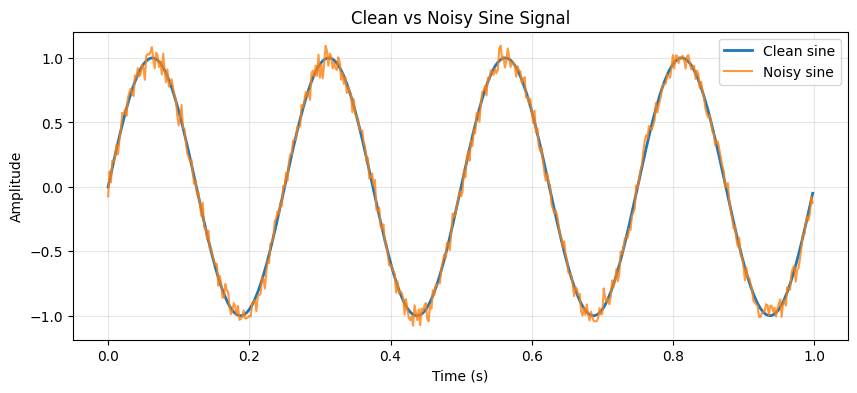

In [5]:
plt.figure(figsize=(10, 4))

plt.plot(t, y_clean, label="Clean sine", linewidth=2.0)
plt.plot(t, y_noisy, label="Noisy sine", linewidth=1.5, alpha=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Clean vs Noisy Sine Signal")
plt.grid(alpha=0.3)
plt.legend()

plt.show()

### What are RBF centers and why do we compute them?

Radial Basis Function (RBF) models use a set of "centers" placed in the input
space to construct a smooth approximation of a function.

Each center corresponds to a Gaussian radial function.  
During training, the model learns how to combine these radial functions to
approximate the target signal.

Why we need centers:

- They define **where** the RBFs are located along the input axis.
- They determine **how locally** or **globally** the model responds to the data.
- They strongly influence the smoothness and accuracy of the final prediction.

In this example we use **KMeans** to select center locations.  
This is a convenient and simple method for creating evenly distributed centers
based on the structure of the input data.

In [6]:
# Select RBF centers using KMeans
N_CLUSTERS = 25 # you can experiment with this value

centers = kmeans_clustering(X_scaled, n_clusters=N_CLUSTERS)

print("Centers shape:", centers.shape)

Centers shape: (25, 1)


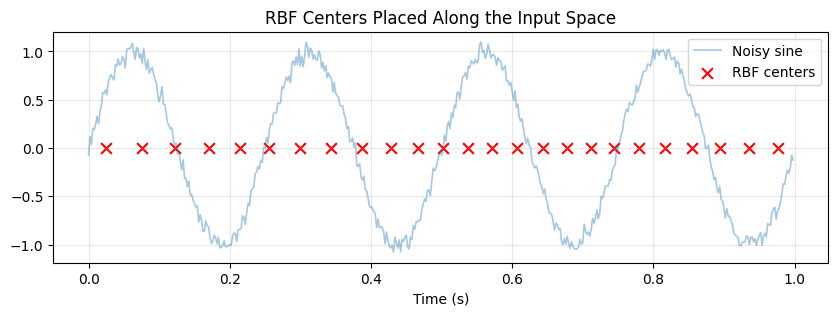

In [7]:
# Convert centers back to original time scale for visualization
centers_t = x_scaler.inverse_transform(centers)

plt.figure(figsize=(10, 3))

# Plot the noisy signal as context
plt.plot(t, y_noisy, label="Noisy sine", alpha=0.4, linewidth=1.2)

# Plot centers as vertical markers
plt.scatter(centers_t[:, 0], 
            np.zeros_like(centers_t[:, 0]), 
            marker='x', 
            color='red', 
            s=60, 
            label="RBF centers")

plt.xlabel("Time (s)")
plt.title("RBF Centers Placed Along the Input Space")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Training the RBF model (fit step)

Once the RBF centers have been placed along the input space, the next step is
to **train** the model so that it can approximate the target function.

During training:

1. Each input point is compared to all centers.  
   This produces a set of radial responses (one value per center).

2. These responses form a matrix of features (one row per sample).  
   The model then learns how to combine these features to match the target
   signal as closely as possible.

3. The training process is a simple **least-squares optimization**.  
   The model finds a set of weights that minimize the difference between the
   predicted curve and the noisy sine wave.

In summary, the training step teaches the model how to transform the distances
to the centers into a smooth approximation of the target signal.

In [8]:
# Create and train the RBF model
N_NEIGHBORS = 7  # number of nearest centers for adaptive sigma

model = RBFModel(centers=centers, n_neighbors=N_NEIGHBORS)
model.fit(X_scaled, y_scaled)

print("Model fitted:", model.fitted_)
print("Sigmas shape:", model.sigmas_.shape)
print("Weights shape:", model.weights_.shape)

Model fitted: True
Sigmas shape: (25,)
Weights shape: (26, 1)


### Making predictions with the trained model

After training, the RBF model has learned how to combine the radial basis
functions in order to approximate the target signal.

The **prediction** step simply applies what the model has learned:

1. Each input point is compared to the centers.
2. The radial responses are computed using the learned sigmas.
3. These responses are combined using the trained weights to produce an output.

In practice, this means that the model can now generate a smooth approximation
of the sine wave for any input value.

In [9]:
# Predict the sine signal using the trained model
y_pred_scaled = model.predict(X_scaled)

# Convert predictions back to the original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled)

print("y_pred shape:", y_pred.shape)

y_pred shape: (500, 1)


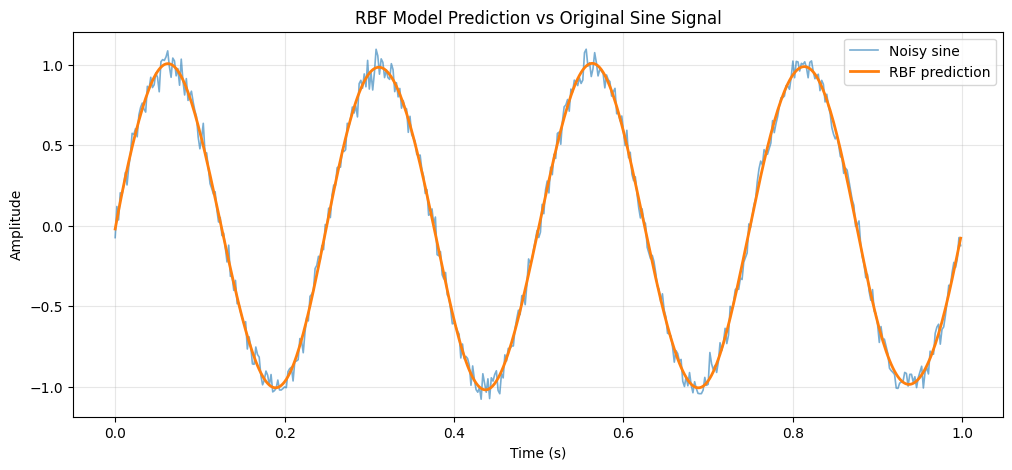

In [10]:
plt.figure(figsize=(12, 5))

# Noisy sine (training target)
plt.plot(t, y_noisy, label="Noisy sine", linewidth=1.2, alpha=0.6)

# RBF prediction
plt.plot(t, y_pred, label="RBF prediction", linewidth=2.0)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("RBF Model Prediction vs Original Sine Signal")

plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Understanding error metrics

After making predictions, we need a way to measure how close the model’s output
is to the actual target signal. Error metrics provide a simple numerical way to
summarize the model’s performance.

In this notebook we use three common metrics:

- **MSE (Mean Squared Error)**  
  Measures the average of the squared differences between prediction and target.
  Larger errors are penalized more strongly.

- **RMSE (Root Mean Squared Error)**  
  The square root of MSE.  
  It has the same units as the original signal, making it easier to interpret.

- **MAE (Mean Absolute Error)**  
  The average absolute difference between prediction and target.  
  More robust to large outliers than MSE.

In simple terms:  
these metrics tell us **how close the predicted curve is to the true signal**.
Smaller values indicate a better approximation.

In [11]:
# Compute error metrics in the original (unscaled) domain
mse = mean_squared_error(y_noisy, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_noisy, y_pred)

print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")

MSE  : 0.002445
RMSE : 0.049452
MAE  : 0.040918
